In [1]:
import os
import time
import math
import random
import pickle
import shutil
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from drift_detectors import *
from forecasters import *
from autoencoder import *
from utils import *
from data import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
# Set a global seed for reproducibility
seed = 42

# Seed Python, NumPy, and PyTorch RNGs
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create and seed a PyTorch Generator (for Dataloaders)
g= torch.Generator()
g.manual_seed(seed)

# Seed CUDA (if available)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior in cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Directory paths for saving and loading components
AE_DIR = "trained_autoencoders"
FORECASTERS_DIR= "trained_forecasters"
RESULTS_DIR = "results"

# Size of the autoencoder bottleneck
latent_dim = 2

# Dataset configurations: (Name, Class, Sequence Length, Window Size)
ts_configs = [
    ("Births",        Births,        None, 10),
    ("SolarPower",    Solar,         None, 10),
    ("WindPower",     Wind,          None, 10),
]

# Flags to toggle use of autoencoder embeddings
autoencoder_embedding_flags = [False, True]
adaptation_set_size = [0.5, 0.25, 0.10]

# Distance metrics to evaluate
metrics_list = ["dtw", "euclidean", "cosine", "manhattan"]

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



Training AE on Births (window_size=10)
  Epoch 1/30 — loss: 0.576391
  Epoch 2/30 — loss: 0.229989
  Epoch 3/30 — loss: 0.172979
  Epoch 4/30 — loss: 0.150268
  Epoch 5/30 — loss: 0.138999
  Epoch 6/30 — loss: 0.123728
  Epoch 7/30 — loss: 0.116097
  Epoch 8/30 — loss: 0.108697
  Epoch 9/30 — loss: 0.103010
  Epoch 10/30 — loss: 0.096774
  Epoch 11/30 — loss: 0.091778
  Epoch 12/30 — loss: 0.085714
  Epoch 13/30 — loss: 0.082574
  Epoch 14/30 — loss: 0.080994
  Epoch 15/30 — loss: 0.079712
  Epoch 16/30 — loss: 0.075311
  Epoch 17/30 — loss: 0.071462
  Epoch 18/30 — loss: 0.070979
  Epoch 19/30 — loss: 0.070608
  Epoch 20/30 — loss: 0.069320
  Epoch 21/30 — loss: 0.068503
  Epoch 22/30 — loss: 0.066283
  Epoch 23/30 — loss: 0.063802
  Epoch 24/30 — loss: 0.062740
  Epoch 25/30 — loss: 0.063268
  Epoch 26/30 — loss: 0.063037
  Epoch 27/30 — loss: 0.059045
  Epoch 28/30 — loss: 0.060655
  Epoch 29/30 — loss: 0.058393
  Epoch 30/30 — loss: 0.060300
Saved AE: trained_autoencoders\ae_Birth

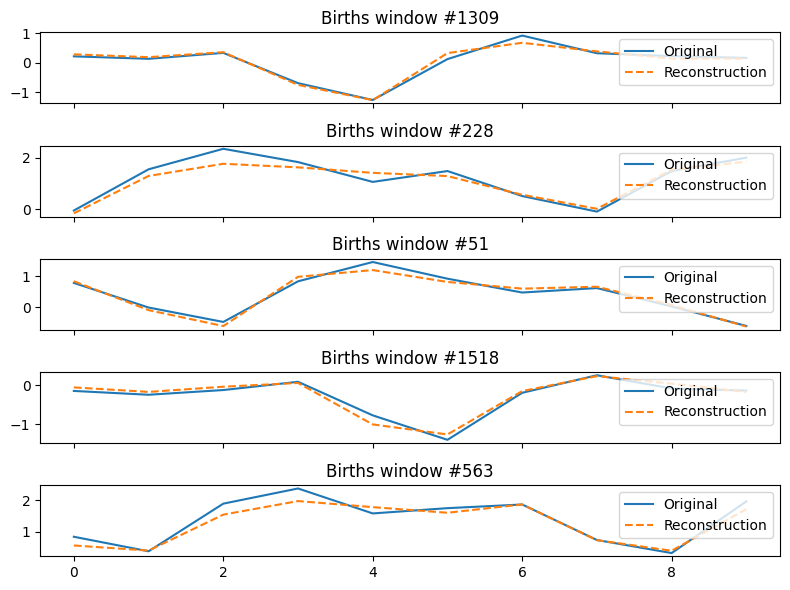


Training AE on SolarPower (window_size=10)
  Epoch 1/30 — loss: 0.557992
  Epoch 2/30 — loss: 0.205635
  Epoch 3/30 — loss: 0.147188
  Epoch 4/30 — loss: 0.123305
  Epoch 5/30 — loss: 0.107384
  Epoch 6/30 — loss: 0.098691
  Epoch 7/30 — loss: 0.091808
  Epoch 8/30 — loss: 0.085992
  Epoch 9/30 — loss: 0.081261
  Epoch 10/30 — loss: 0.074423
  Epoch 11/30 — loss: 0.073080
  Epoch 12/30 — loss: 0.070768
  Epoch 13/30 — loss: 0.066075
  Epoch 14/30 — loss: 0.066174
  Epoch 15/30 — loss: 0.063004
  Epoch 16/30 — loss: 0.061777
  Epoch 17/30 — loss: 0.061714
  Epoch 18/30 — loss: 0.057734
  Epoch 19/30 — loss: 0.059372
  Epoch 20/30 — loss: 0.057477
  Epoch 21/30 — loss: 0.055316
  Epoch 22/30 — loss: 0.055623
  Epoch 23/30 — loss: 0.054378
  Epoch 24/30 — loss: 0.055739
  Epoch 25/30 — loss: 0.053159
  Epoch 26/30 — loss: 0.051023
  Epoch 27/30 — loss: 0.051714
  Epoch 28/30 — loss: 0.050163
  Epoch 29/30 — loss: 0.048562
  Epoch 30/30 — loss: 0.048331
Saved AE: trained_autoencoders\ae_S

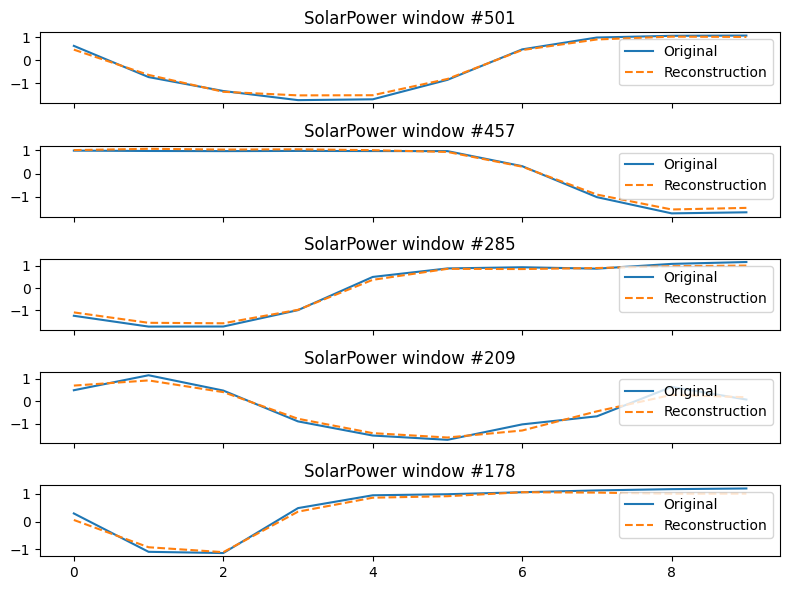


Training AE on WindPower (window_size=10)
  Epoch 1/30 — loss: 0.334567
  Epoch 2/30 — loss: 0.143737
  Epoch 3/30 — loss: 0.114560
  Epoch 4/30 — loss: 0.100690
  Epoch 5/30 — loss: 0.100480
  Epoch 6/30 — loss: 0.116974
  Epoch 7/30 — loss: 0.080403
  Epoch 8/30 — loss: 0.095247
  Epoch 9/30 — loss: 0.085301
  Epoch 10/30 — loss: 0.066506
  Epoch 11/30 — loss: 0.064993
  Epoch 12/30 — loss: 0.061749
  Epoch 13/30 — loss: 0.073806
  Epoch 14/30 — loss: 0.081078
  Epoch 15/30 — loss: 0.072927
  Epoch 16/30 — loss: 0.055034
  Epoch 17/30 — loss: 0.058102
  Epoch 18/30 — loss: 0.046854
  Epoch 19/30 — loss: 0.049371
  Epoch 20/30 — loss: 0.061597
  Epoch 21/30 — loss: 0.048454
  Epoch 22/30 — loss: 0.050783
  Epoch 23/30 — loss: 0.046718
  Epoch 24/30 — loss: 0.044067
  Epoch 25/30 — loss: 0.045517
  Epoch 26/30 — loss: 0.042008
  Epoch 27/30 — loss: 0.058899
  Epoch 28/30 — loss: 0.049218
  Epoch 29/30 — loss: 0.041367
  Epoch 30/30 — loss: 0.042817
Saved AE: trained_autoencoders\ae_Wi

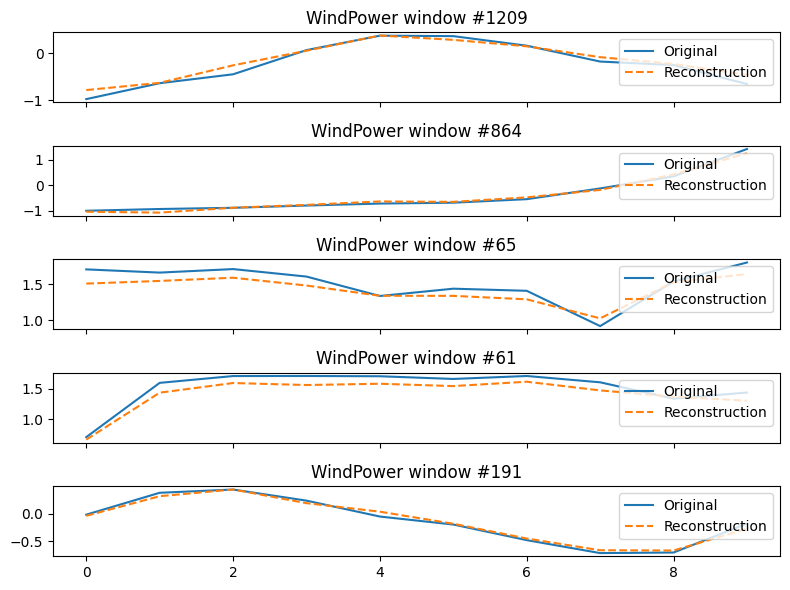

In [4]:
# Autoencoder Training Settings
epochs    = 30
lr        = 1e-3
dropout_p = 0.3

# Ensure a clean autoencoders/ directory
if os.path.exists(AE_DIR):
    shutil.rmtree(AE_DIR)
os.makedirs(AE_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=128, 
        shuffle=True, 
        generator= g
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_val)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [5]:
# Ensure a clean forecasters/ directory
if os.path.exists(FORECASTERS_DIR):
    shutil.rmtree(FORECASTERS_DIR)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(trend="add"),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(n_estimators= 50, max_depth=3, random_state=seed),
    "SVR": SVRForecaster(kernel='rbf', C=1.0, epsilon=0.05),
    "GradientBoosting": GradientBoostingForecaster(n_estimators=50, max_depth=2, random_state=seed),
    "DT": DecisionTreeForecaster(max_depth=3, min_samples_split=4, random_state=seed),
    "MLP1": MLPForecaster(hidden_layer_sizes=(64,), random_state=seed),
    "MLP2": MLPForecaster(hidden_layer_sizes=(64, 32), random_state=seed),
    "MLP3": MLPForecaster(hidden_layer_sizes=(128, 64, 32), random_state=seed),
    "LSTM1": LSTMForecaster(hidden_size=32,
                            num_layers=1,
                            dropout=0.0,
                            lr=1e-3,
                            epochs=30,
                            batch_size=64
                            ),
    "LSTM2": LSTMForecaster(hidden_size=64,
                            num_layers=2,
                            dropout=0.2,
                            lr=1e-3,
                            epochs=40,
                            batch_size=64
            ),
    "LSTM3": LSTMForecaster(hidden_size=128,
                            num_layers=3,
                            dropout=0.3,
                            lr=5e-4,
                            epochs=50,
                            batch_size=64
            ),
    "BiLSTM1": BiLSTMForecaster(hidden_size=32,
                                num_layers=1,
                                dropout=0.0,
                                lr=1e-3,
                                epochs=30,
                                batch_size=64
            ),
    "BiLSTM2": BiLSTMForecaster(hidden_size=64,
                                num_layers=2,
                                dropout=0.2,
                                lr=1e-3,
                                epochs=40,
                                batch_size=64
            ),
    "BiLSTM3": BiLSTMForecaster(hidden_size=128,
                                num_layers=3,
                                dropout=0.3,
                                lr=5e-4,
                                epochs=50,
                                batch_size=64
            ),
    "CNNLSTM1": CNNLSTMForecaster(conv_channels=(16,),
                                kernel_size=3,
                                lstm_hidden_size=32,
                                lstm_num_layers=1,
                                dropout=0.1,
                                lr=1e-3,
                                epochs=30,
                                batch_size=64
            ),
    "CNNLSTM2": CNNLSTMForecaster(conv_channels=(32, 64),
                                kernel_size=3,
                                lstm_hidden_size=64,
                                lstm_num_layers=2,
                                dropout=0.2,
                                lr=1e-3,
                                epochs=40,
                                batch_size=64
            ),
    "CNNLSTM3": CNNLSTMForecaster(conv_channels=(32, 64, 64),
                                kernel_size=3,
                                lstm_hidden_size=128,
                                lstm_num_layers=3,
                                dropout=0.3,
                                lr=5e-4,
                                epochs=50,
                                batch_size=64
            ),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train, generator=g)

        # save the entire model object as a .pkl
        save_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE")


→ Dataset: Births (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP1… DONE
    → Training MLP2… DONE
    → Training MLP3… DONE
    → Training LSTM1… 1/30 0.77708 | 15/30 0.13700 | 30/30 0.10949 | DONE
    → Training LSTM2… 1/40 0.72114 | 15/40 0.15819 | 30/40 0.10539 | 40/40 0.09265 | DONE
    → Training LSTM3… 1/50 0.70650 | 15/50 0.17783 | 30/50 0.13625 | 45/50 0.10647 | 50/50 0.09990 | DONE
    → Training BiLSTM1… 1/30 0.86956 | 15/30 0.17202 | 30/30 0.11229 | DONE
    → Training BiLSTM2… 1/40 0.70366 | 15/40 0.12479 | 30/40 0.10165 | 40/40 0.09233 | DONE
    → Training BiLSTM3… 1/50 0.70583 | 15/50 0.12737 | 30/50 0.10658 | 45/50 0.09383 | 50/50 0.09202 | DONE
    → Training CNNLSTM1… 1/30 0.76339 | 15/30 0.12408 | 30/30 0.10347 | DONE
    → Training CNNLSTM2… 1/40 0.68693 | 15/

In [6]:
os.makedirs(AE_DIR, exist_ok=True)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

loaded = {}
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {AE_DIR}{os.sep}")
    
    # Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP1",
        "MLP2",
        "MLP3",
        "LSTM1",
        "LSTM2",
        "LSTM3",
        "BiLSTM1",
        "BiLSTM2",
        "BiLSTM3",
        "CNNLSTM1",
        "CNNLSTM2",
        "CNNLSTM3",
    ]:
        pkl_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
    print(f"     Forecasters loaded from {FORECASTERS_DIR}{os.sep}")
    
    # Store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Births (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for SolarPower (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for WindPower (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\


In [7]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")


=== Validation RoC for Births (window_size=10) ===
RoC sizes
  ARIMA                41 entries
  ExpSmoothing         30 entries
  LinearRegression    112 entries
  RandomForest        147 entries
  SVR                  86 entries
  GradientBoosting    123 entries
  DT                  129 entries
  MLP1                115 entries
  MLP2                115 entries
  MLP3                136 entries
  LSTM1                95 entries
  LSTM2                78 entries
  LSTM3               123 entries
  BiLSTM1              55 entries
  BiLSTM2              77 entries
  BiLSTM3             135 entries
  CNNLSTM1             68 entries
  CNNLSTM2             69 entries
  CNNLSTM3             82 entries

=== Validation RoC for SolarPower (window_size=10) ===
RoC sizes
  ARIMA                89 entries
  ExpSmoothing         73 entries
  LinearRegression     87 entries
  RandomForest         42 entries
  SVR                 108 entries
  GradientBoosting     53 entries
  DT                  

Bottleneck size: 2

=== Compute K-means centers for Births (window_size=10) ===


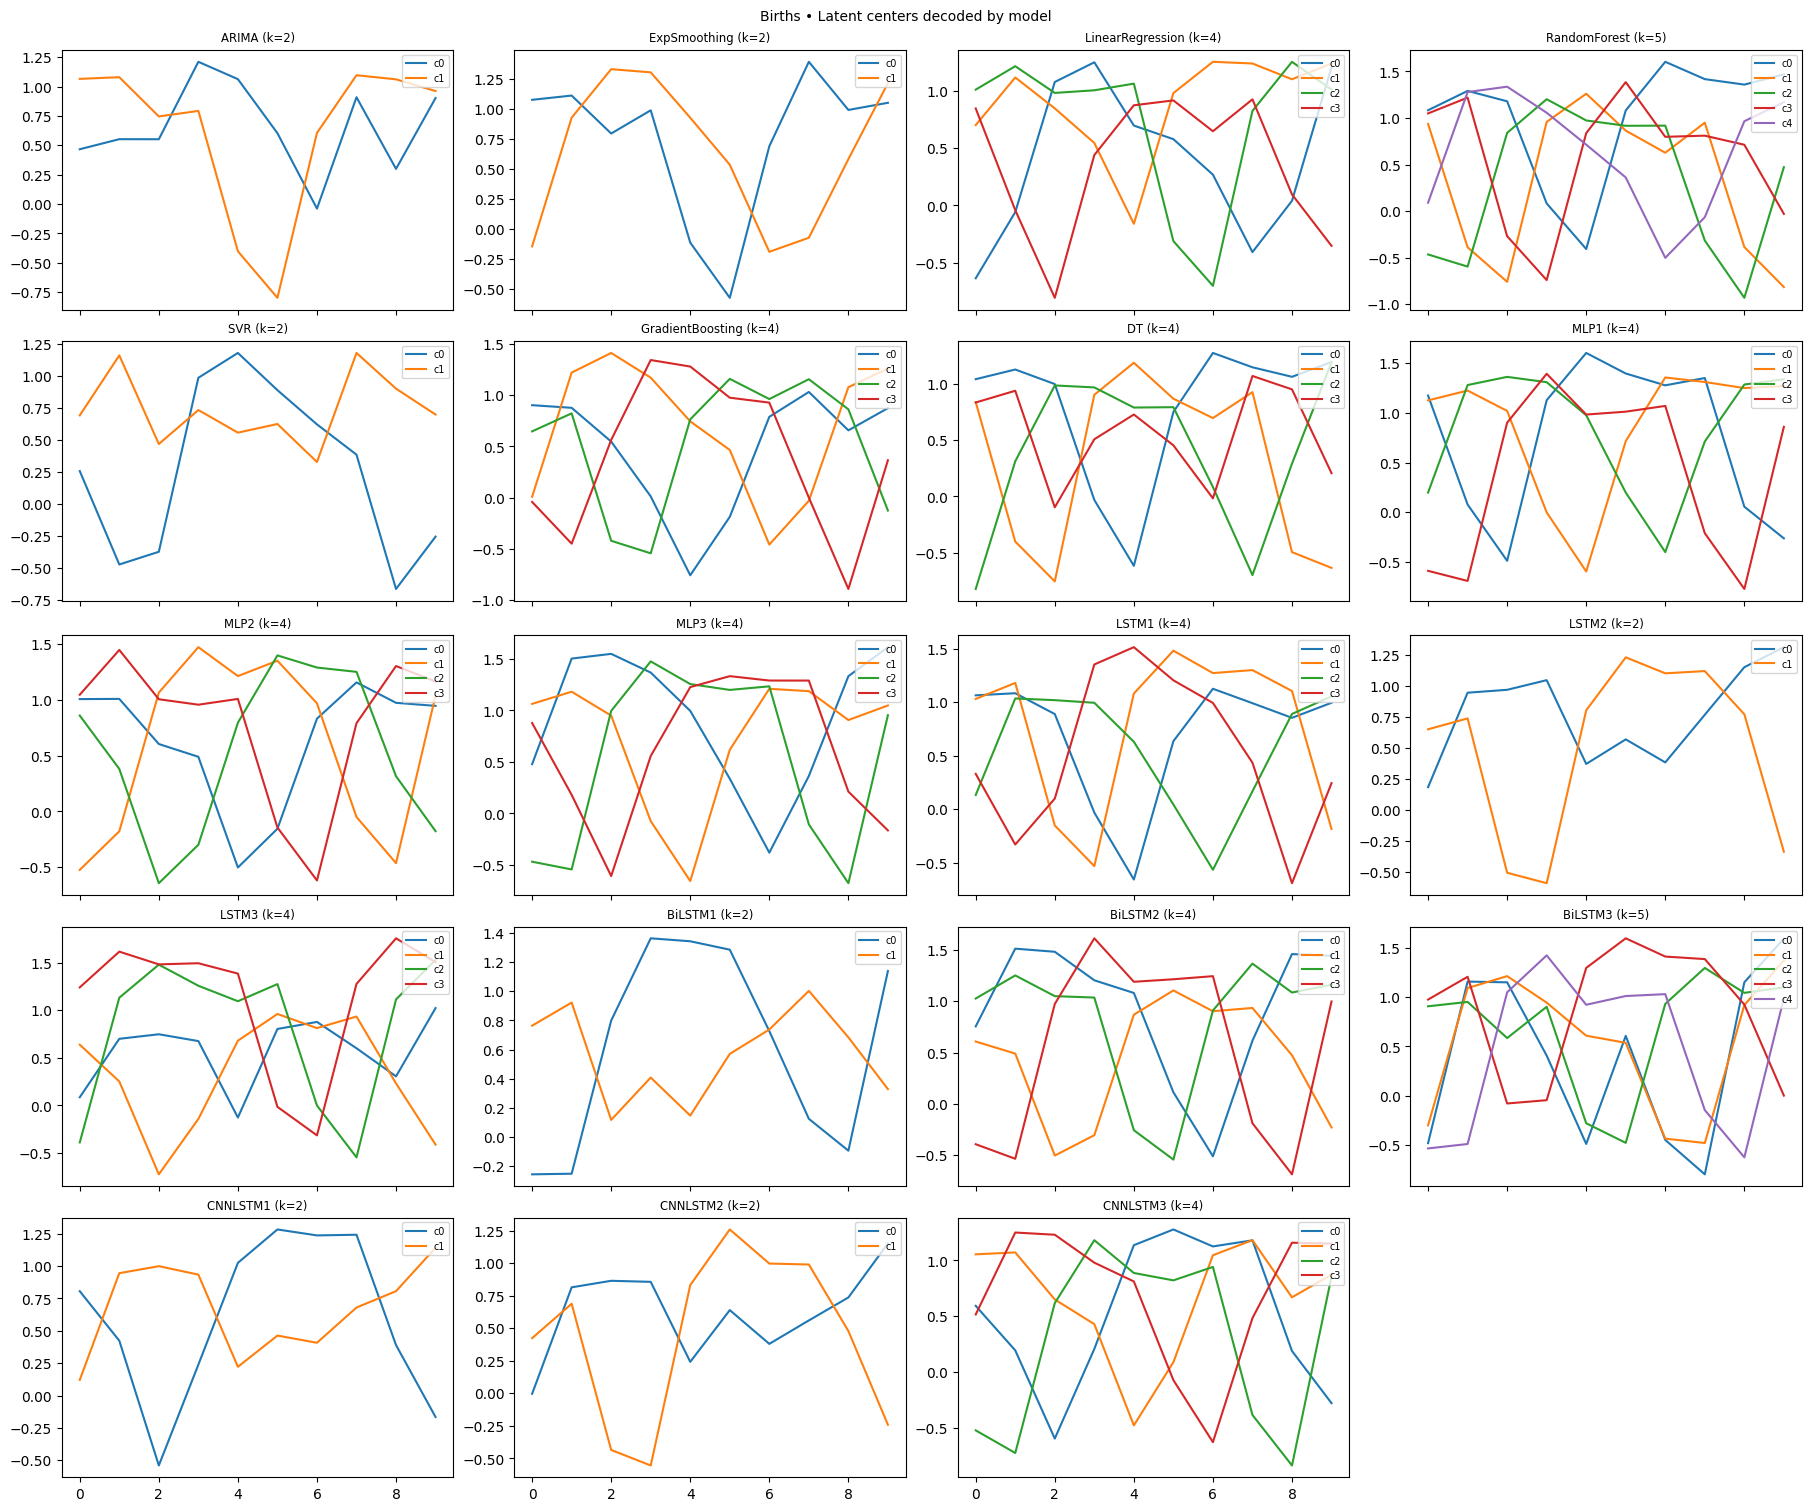


=== Compute K-means centers for SolarPower (window_size=10) ===


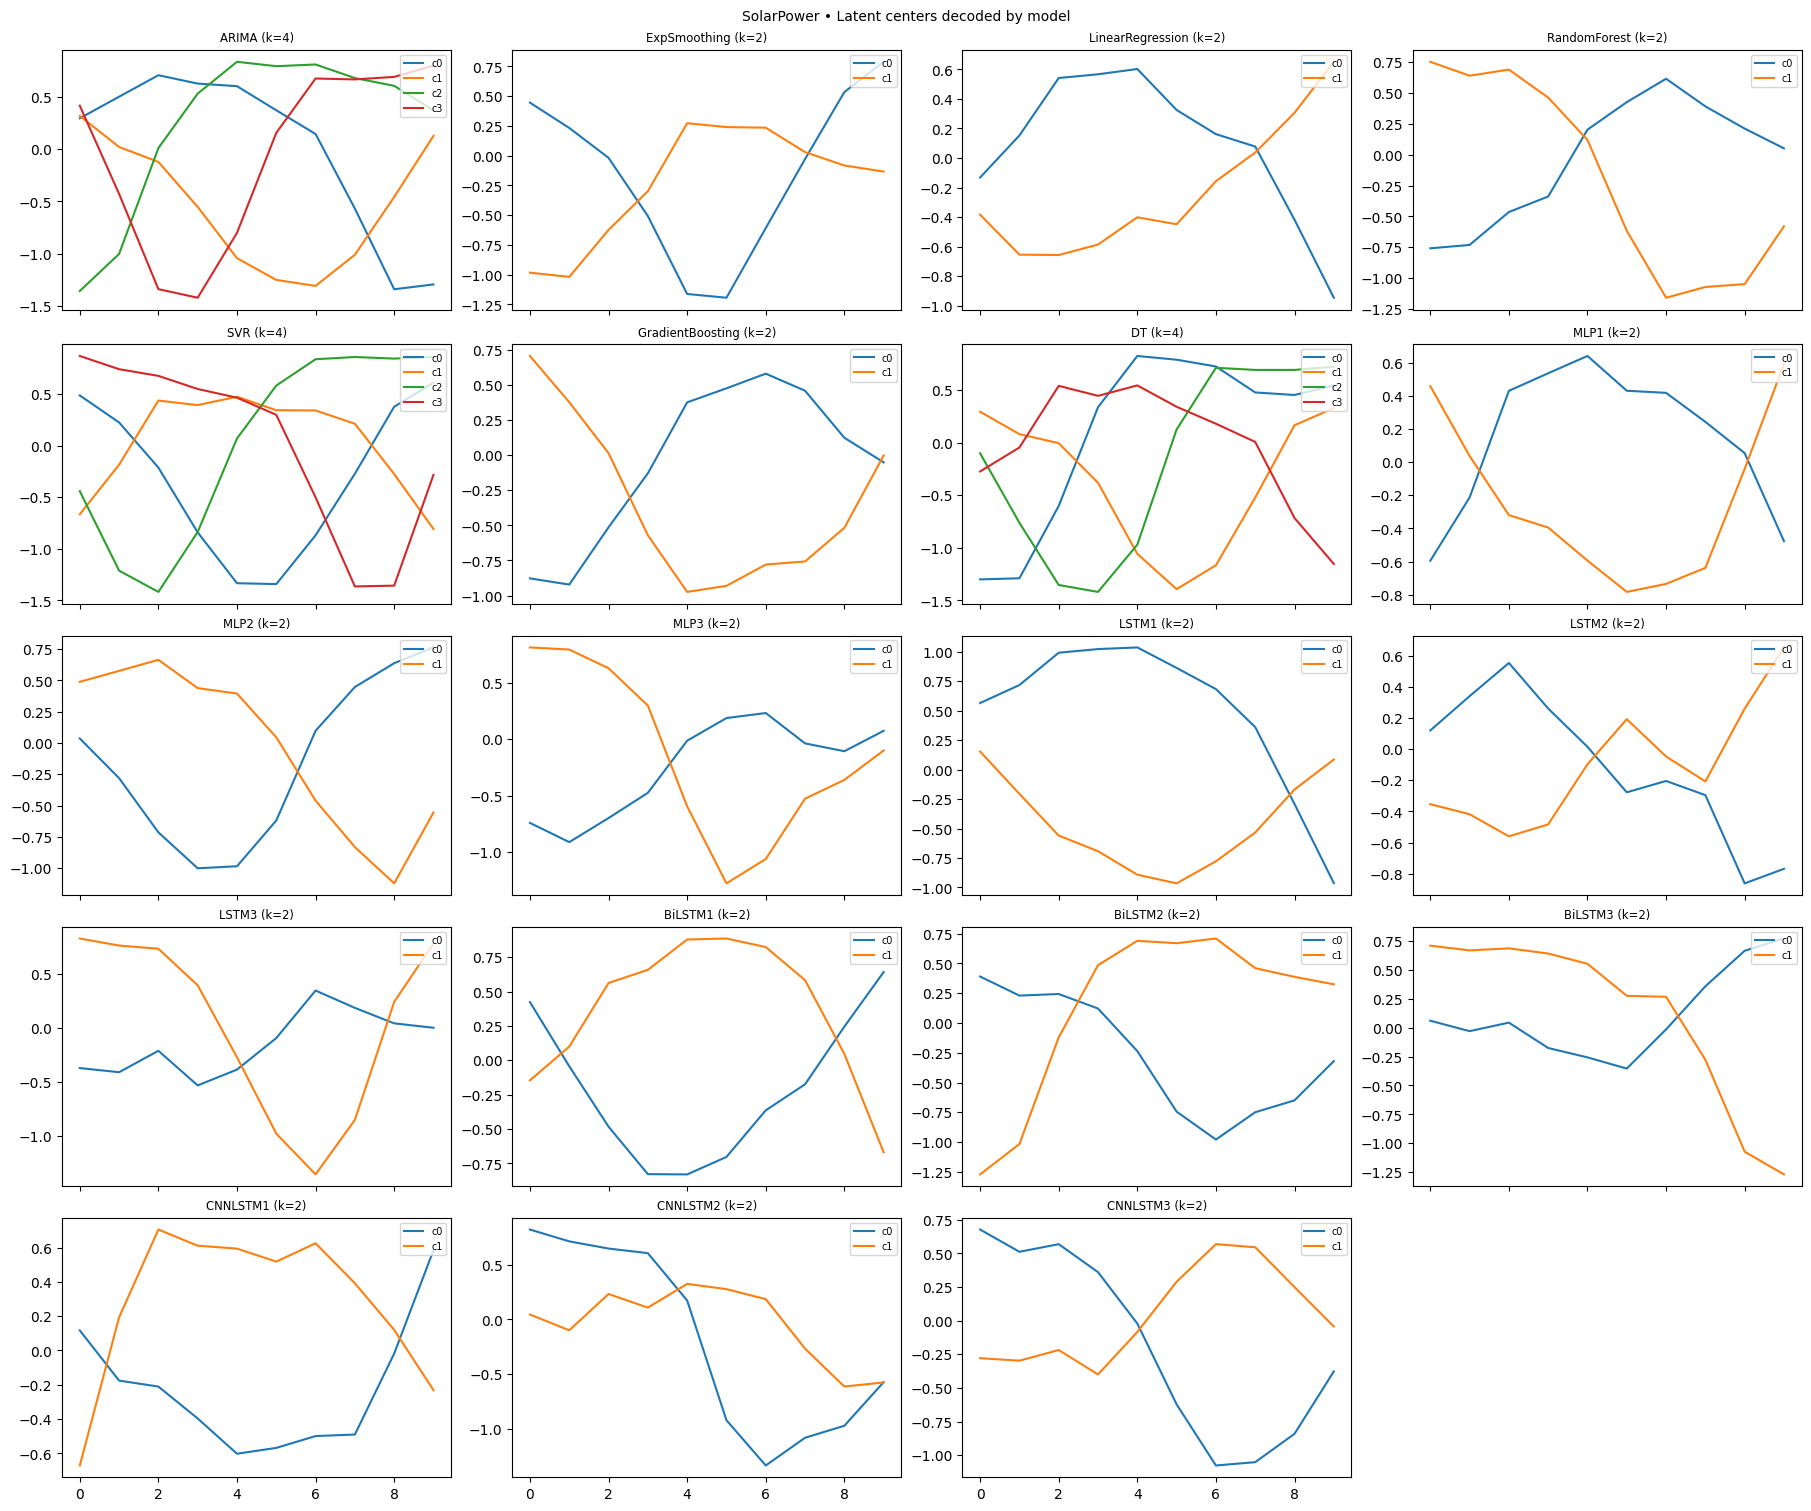


=== Compute K-means centers for WindPower (window_size=10) ===


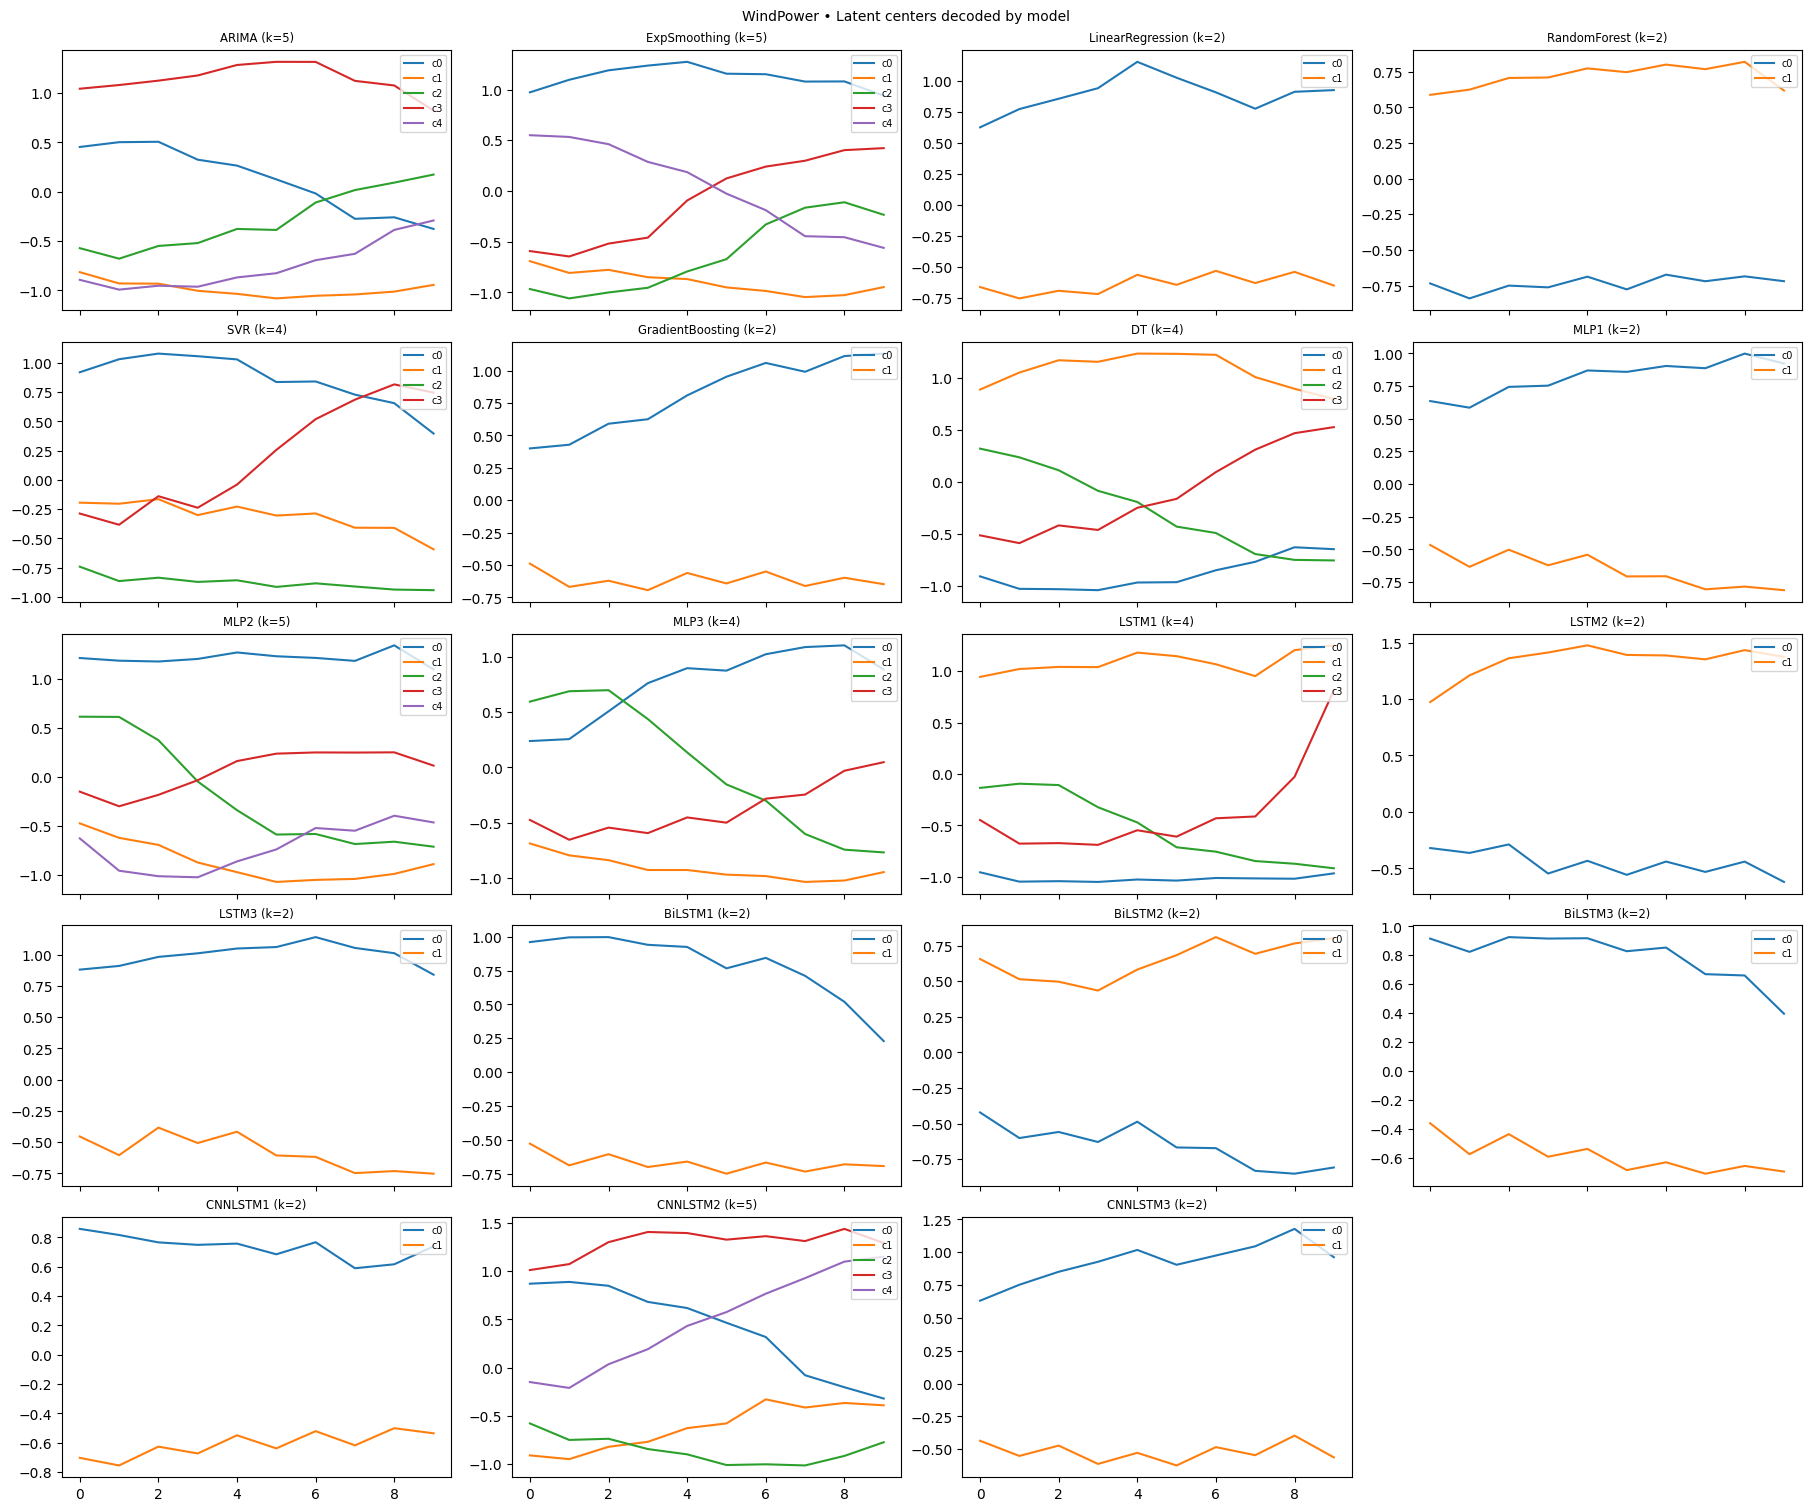

In [8]:
n_cols = 4
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Compute K-means centers for {ds_name} (window_size={window_size}) ===")

    # Load models
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear previous centers
    for model in forecasters.values():
        model.centers = {"raw": [], "latent": []}

    # Determine device for decoding latent centers
    decoder_device = next(ae.decoder.parameters()).device

    for name, model in forecasters.items():
        # Cluster latent RoCs
        N_latent = len(model.rocs["latent"])
        if N_latent > 0:
            k_max_latent = np.sqrt(N_latent / 2)
            model.compute_kmeans_centers(mode="latent", k_max=k_max_latent, random_state=seed)

        # Cluster raw RoCs
        N_raw = len(model.rocs["raw"])
        if N_raw > 0:
            k_max_raw = np.sqrt(N_raw / 2)
            model.compute_kmeans_centers(mode="raw", k_max=k_max_raw, random_state=seed)

    # Plot all latent cluster centers (decoded)
    names = [n for n in forecasters if len(forecasters[n].centers["latent"]) > 0]
    n_models = len(names)
    if n_models == 0:
        print(" No models have centers to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, name in zip(axes, names):
        model = forecasters[name]
        for idx, c in enumerate(model.centers["latent"]):
            # ensure tensor on correct device
            c_tensor = c if isinstance(c, torch.Tensor) else torch.tensor(
                c, dtype=torch.float32
            )
            c_batch = c_tensor.unsqueeze(0).to(decoder_device)  # shape (1, C, L)
            decoded = ae.decoder(c_batch)                       # -> (1, 1, window_size)
            ts_data = decoded.detach().cpu().numpy().flatten()
            ax.plot(ts_data, label=f"c{idx}")
        ax.set_title(f"{name} (k={len(model.centers['latent'])})", fontsize="small")
        ax.legend(loc="upper right", fontsize="x-small")

    # turn off any unused subplots
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent centers decoded by model", fontsize="medium")
    plt.show()

In [9]:
def retrain_autoencoder(X, ds_name, batch_size=128):

    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()

    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X, dtype=torch.float).unsqueeze(1)),
        batch_size=batch_size,
        shuffle=True,
        generator=g
    )

    for epoch in range(1, epochs + 1):
        ae.train()
        losses = []
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon = ae(batch_x)
            loss = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    ckpt_path = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)

    return ae.eval()

In [10]:
def rebuild_rocs(ae, forecasters, X, y, append=False):
    """
    Rebuilds or appends to each model's Region of Competence (RoC) based on validation data.
    """
    if not append:
        for model in forecasters.values():
            model.rocs["raw"].clear()
            model.rocs["latent"].clear()

    ae.eval()
    for idx, window in enumerate(X):
        errors = {
            name: mean_squared_error([y[idx]], [model.predict(window)])
            for name, model in forecasters.items()
        }
        winner = min(errors, key=errors.get)

        # Encode latent vector
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(window)
        forecasters[winner].rocs["latent"].append(latent_vec)

    return forecasters

> Bottleneck size: 2
> Detectors and parameters:
  None: None (no drift detection)
  ZScore: buffer_size=175, z_threshold=3.5, retain_fraction=0.1
  Percentile: buffer_size=200, percentile=98.5, retain_fraction=0.1
  HDDM_A: delta=0.0019
  HDDM_W: delta=0.009, alpha=0.85

=== Dataset: Births ===
[Metric: manhattan] Detector: None       | MSE: 0.2220 | Time: 30.84s | Drifts: 0


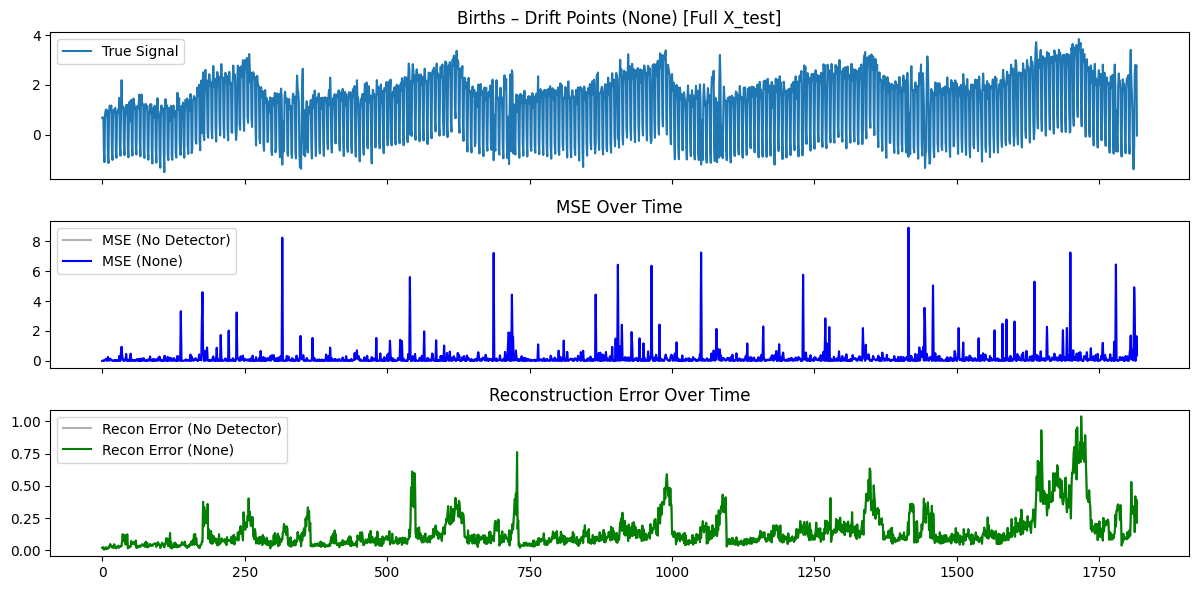

[Metric: manhattan] Detector: ZScore     | MSE: 0.2243 | Time: 332.74s | Drifts: 7


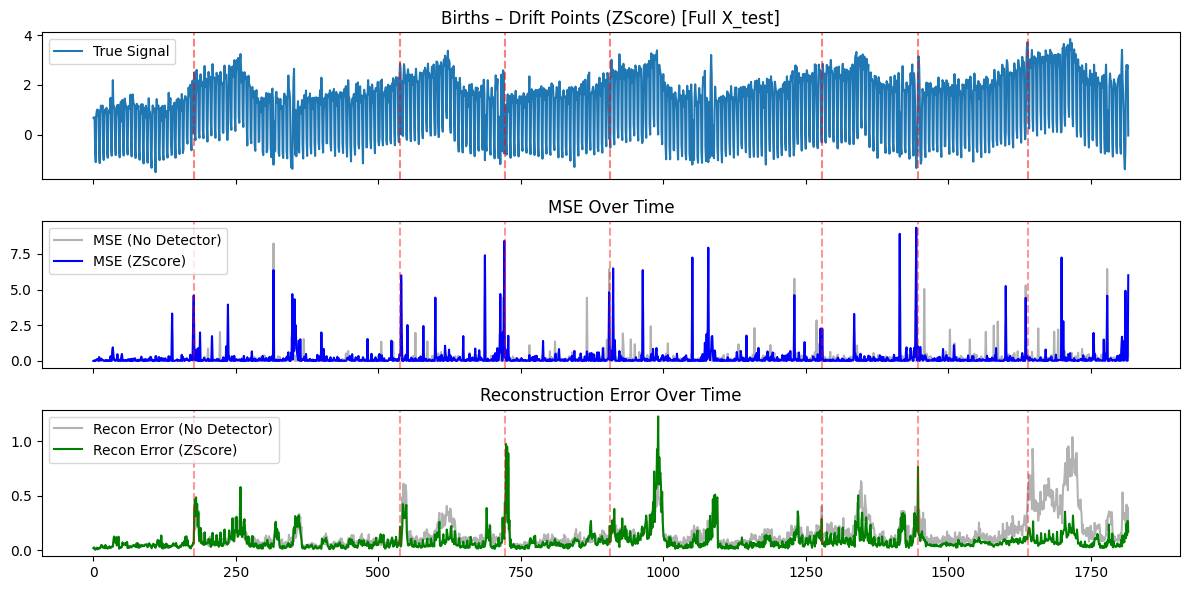

[Metric: manhattan] Detector: Percentile | MSE: 0.2290 | Time: 225.96s | Drifts: 5


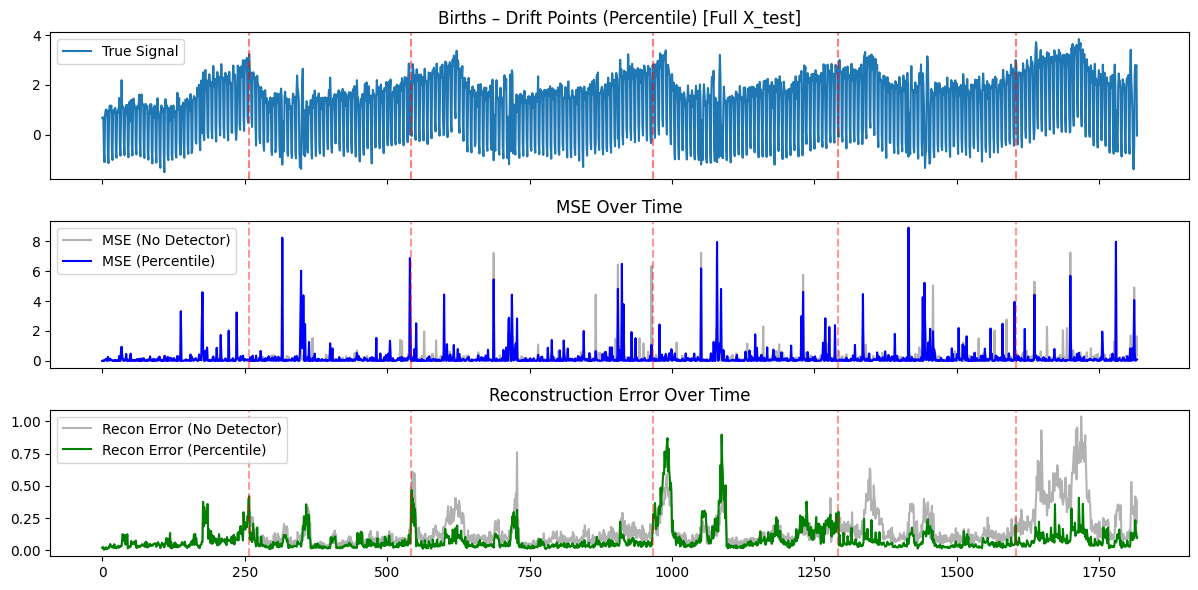

[Metric: manhattan] Detector: HDDM_A     | MSE: 0.2248 | Time: 489.27s | Drifts: 12


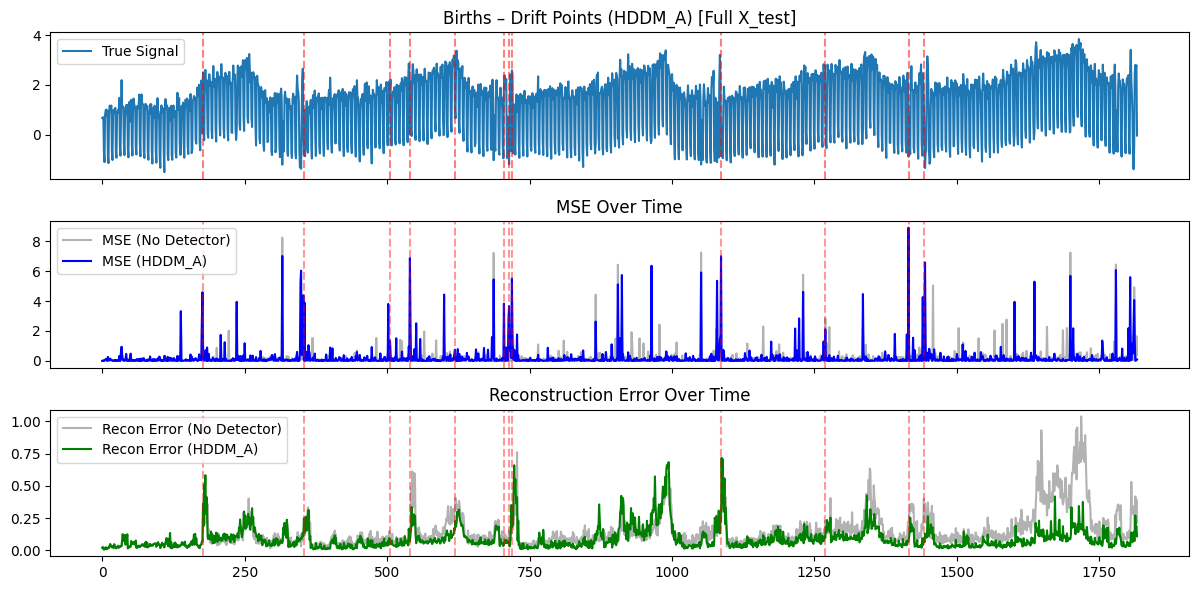

[Metric: manhattan] Detector: HDDM_W     | MSE: 0.2220 | Time: 30.40s | Drifts: 0


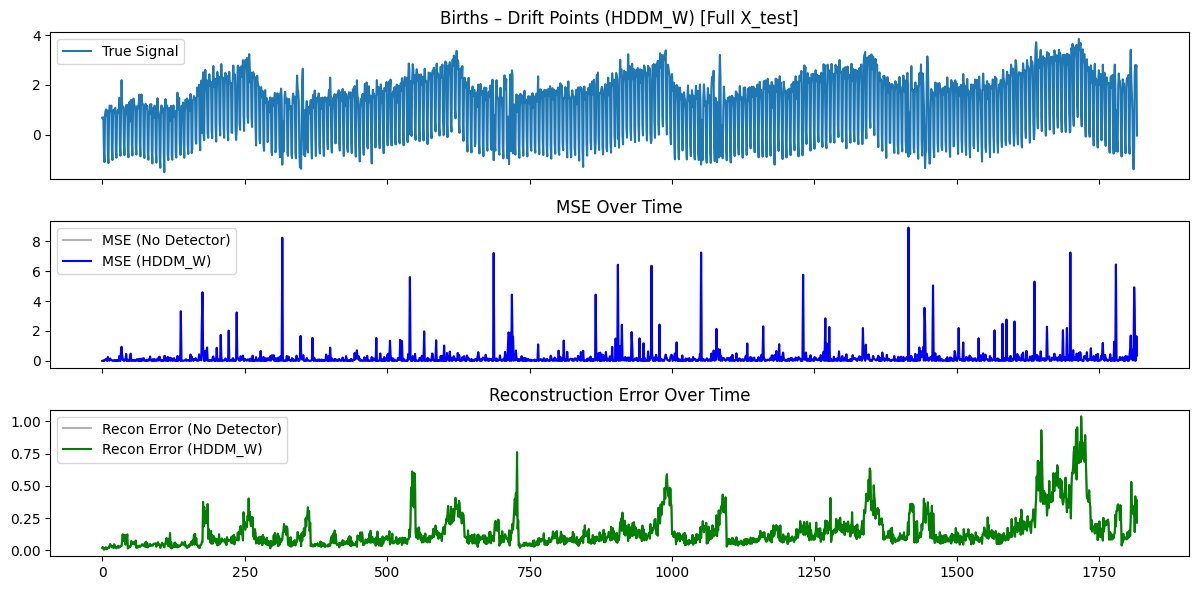


=== Dataset: SolarPower ===
[Metric: manhattan] Detector: None       | MSE: 0.2764 | Time: 12.83s | Drifts: 0


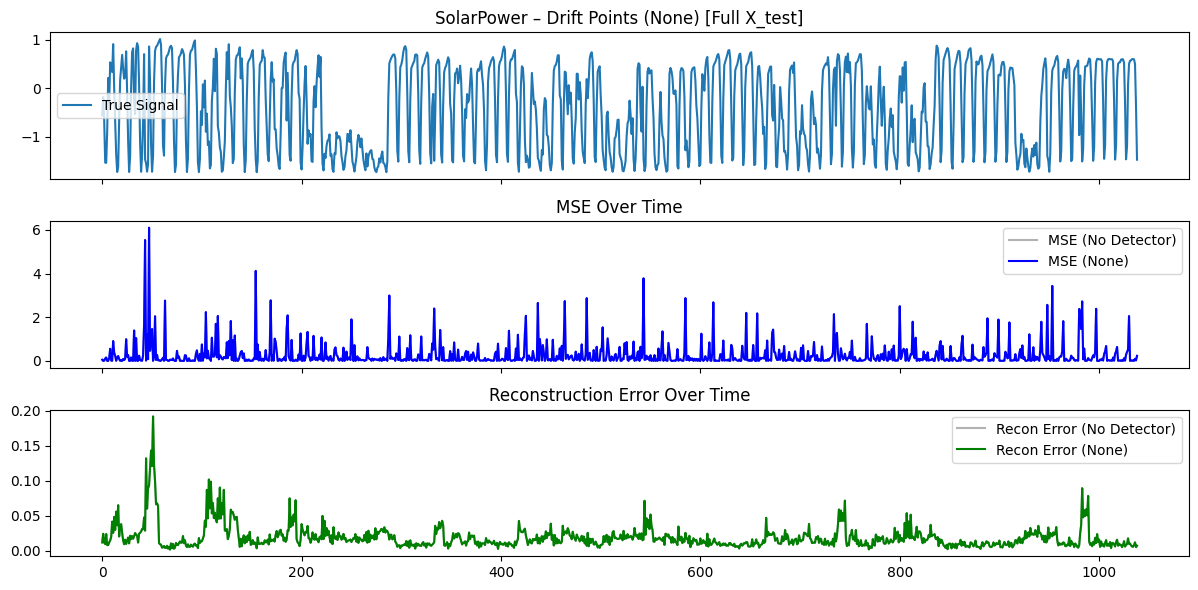

[Metric: manhattan] Detector: ZScore     | MSE: 0.2322 | Time: 71.88s | Drifts: 3


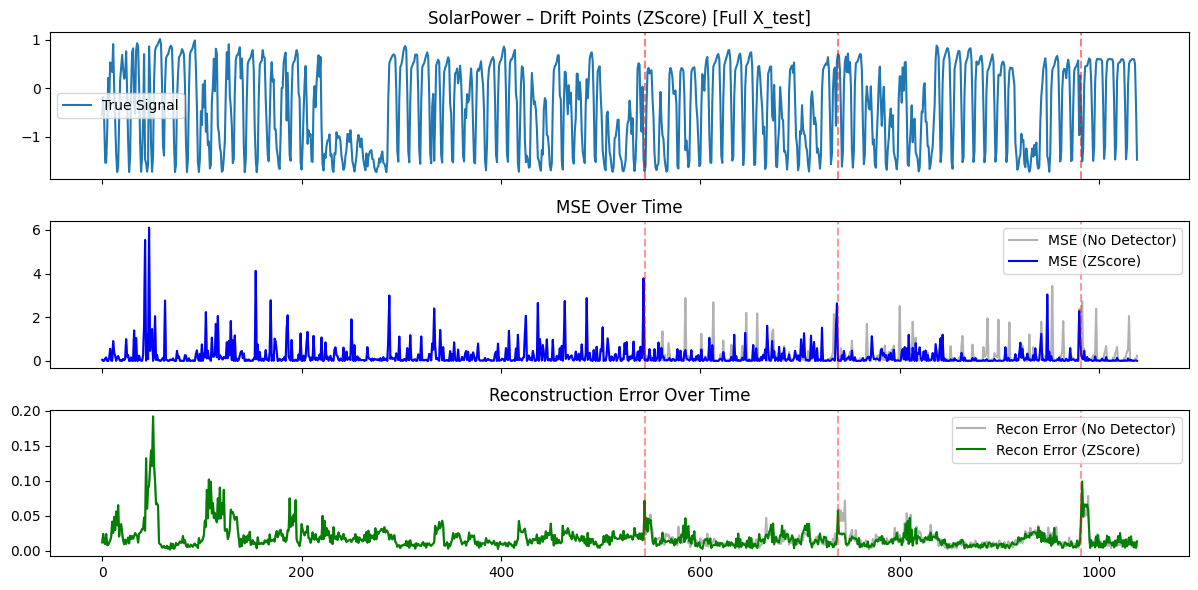

[Metric: manhattan] Detector: Percentile | MSE: 0.2387 | Time: 71.47s | Drifts: 3


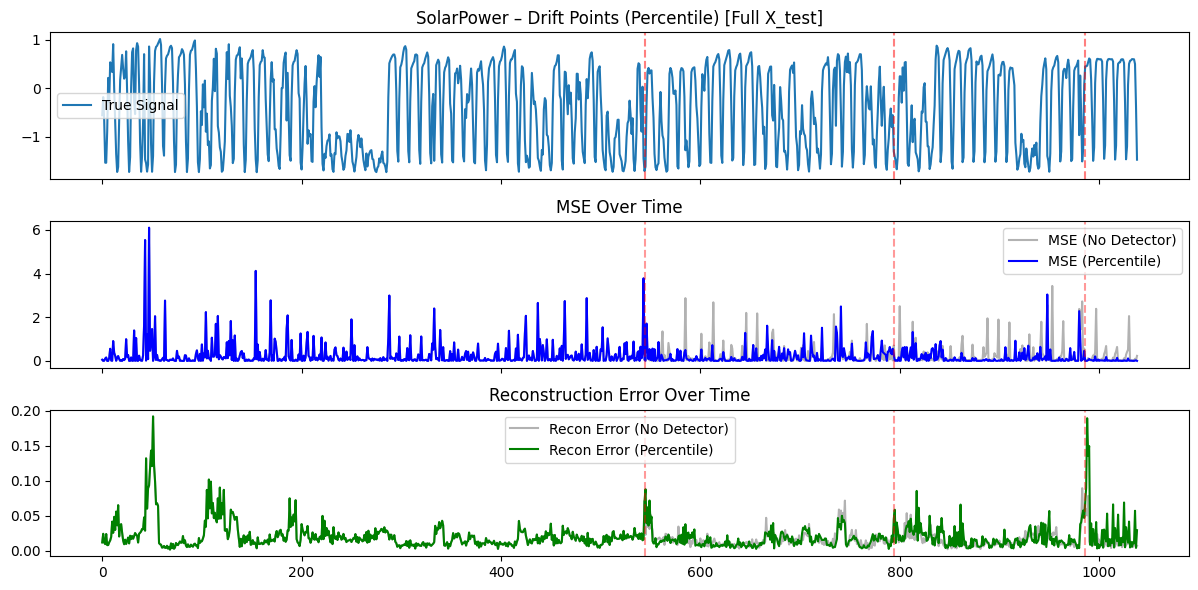

[Metric: manhattan] Detector: HDDM_A     | MSE: 0.2447 | Time: 65.63s | Drifts: 2


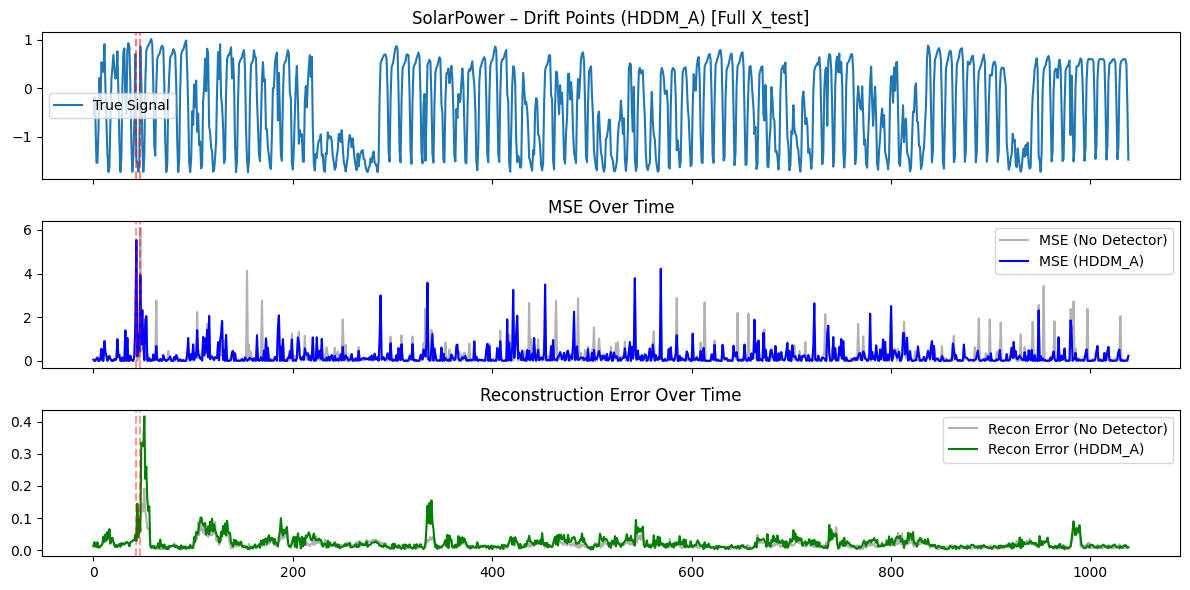

[Metric: manhattan] Detector: HDDM_W     | MSE: 0.2639 | Time: 41.46s | Drifts: 1


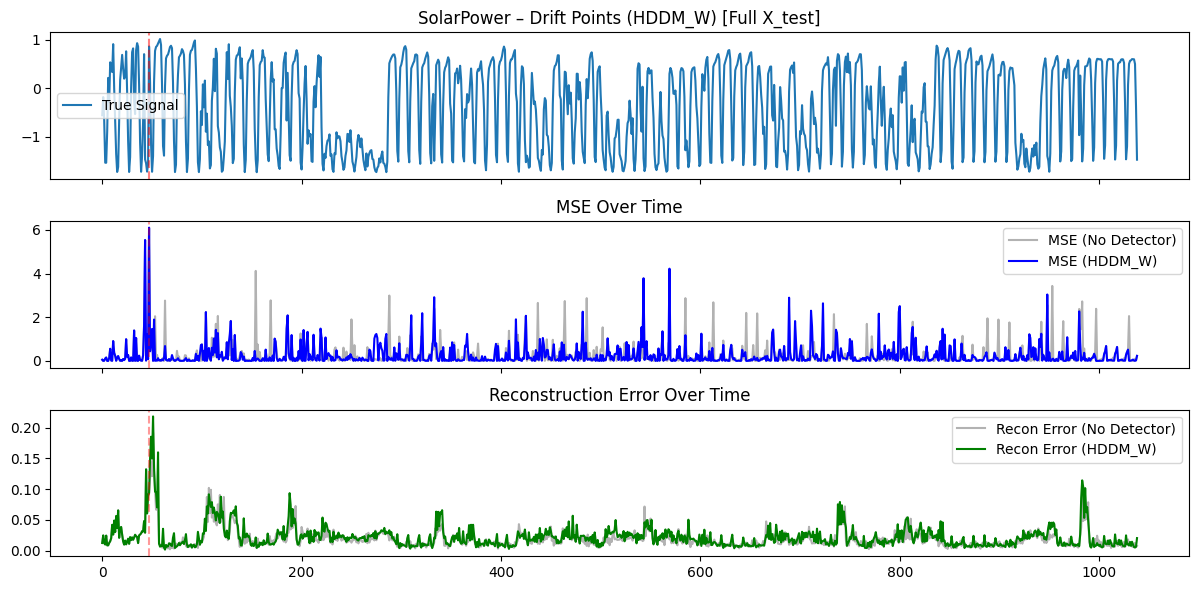


=== Dataset: WindPower ===
[Metric: manhattan] Detector: None       | MSE: 0.0922 | Time: 42.63s | Drifts: 0


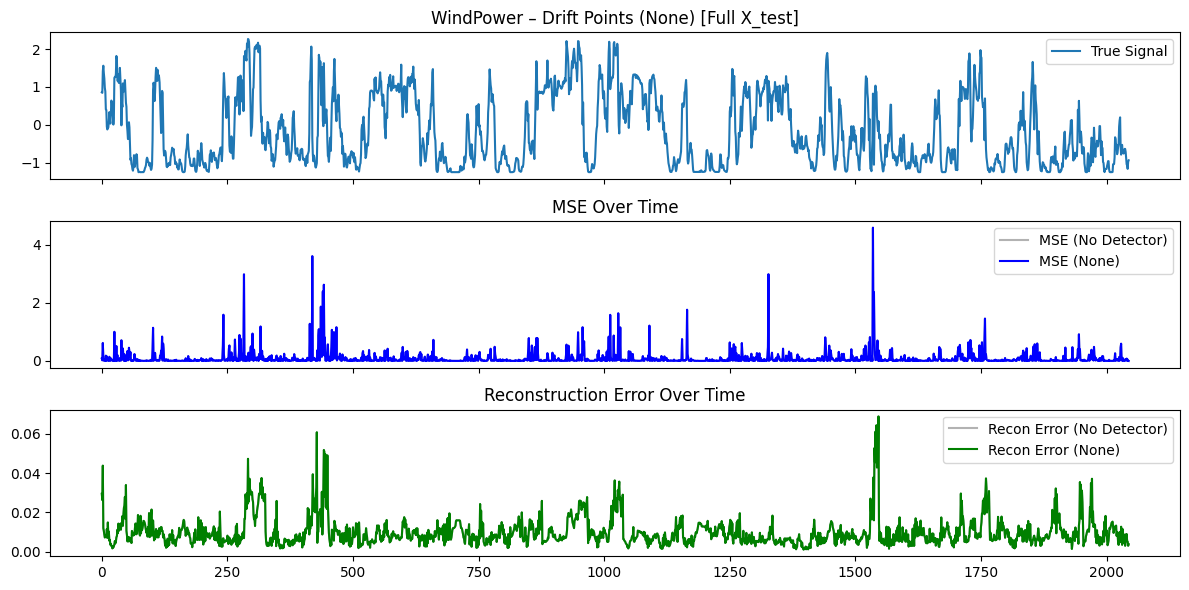

[Metric: manhattan] Detector: ZScore     | MSE: 0.0938 | Time: 410.58s | Drifts: 7


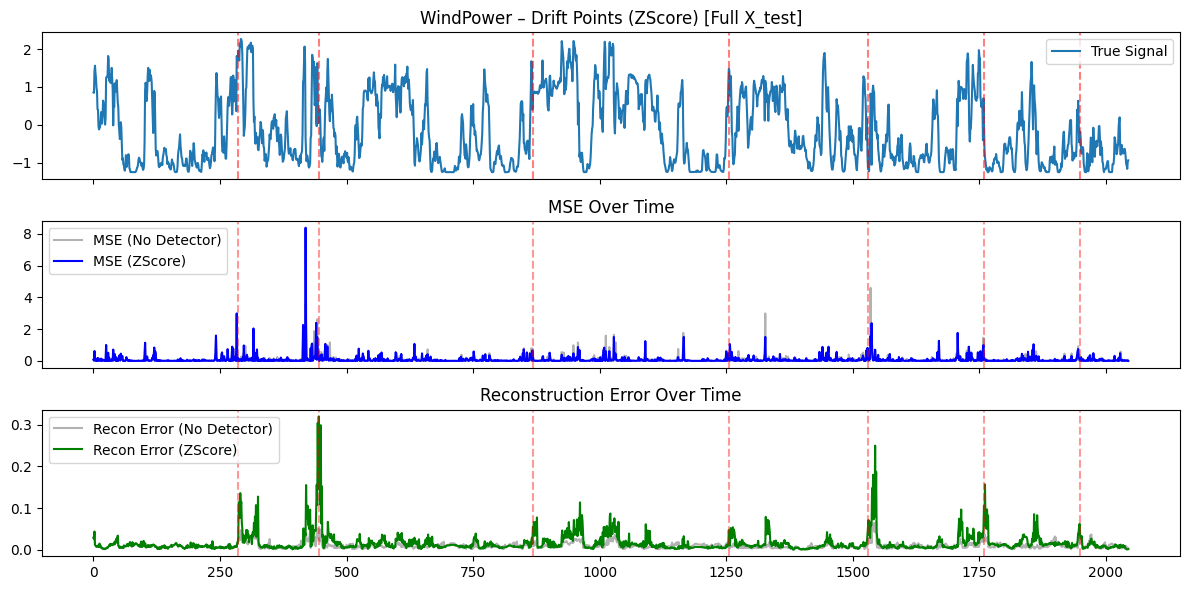

[Metric: manhattan] Detector: Percentile | MSE: 0.0919 | Time: 361.17s | Drifts: 6


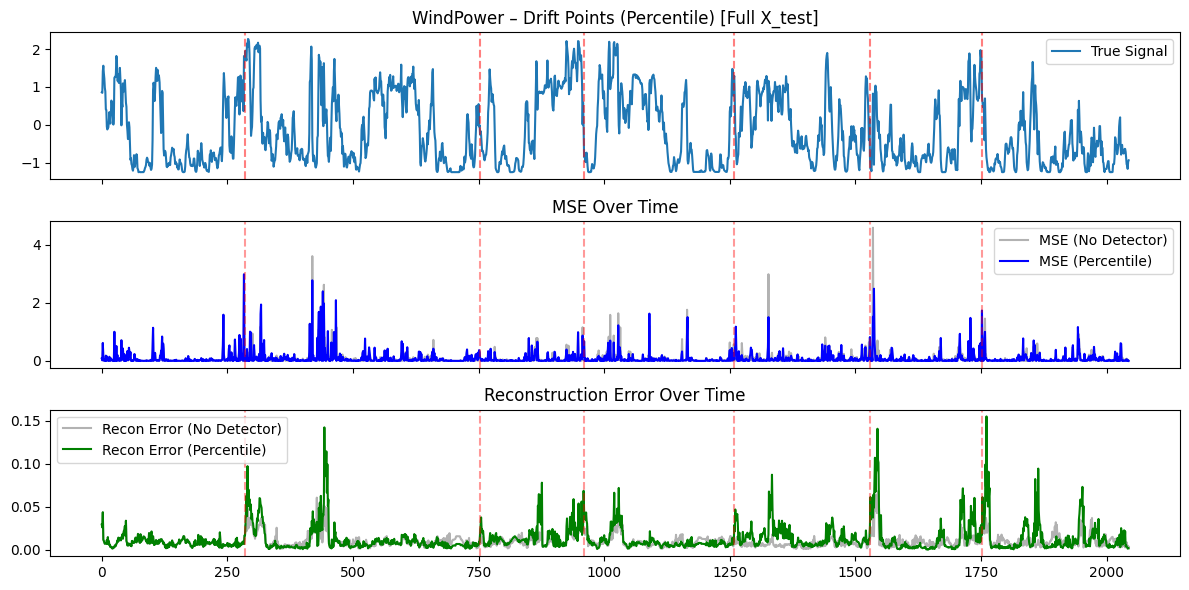

[Metric: manhattan] Detector: HDDM_A     | MSE: 0.0939 | Time: 85.35s | Drifts: 1


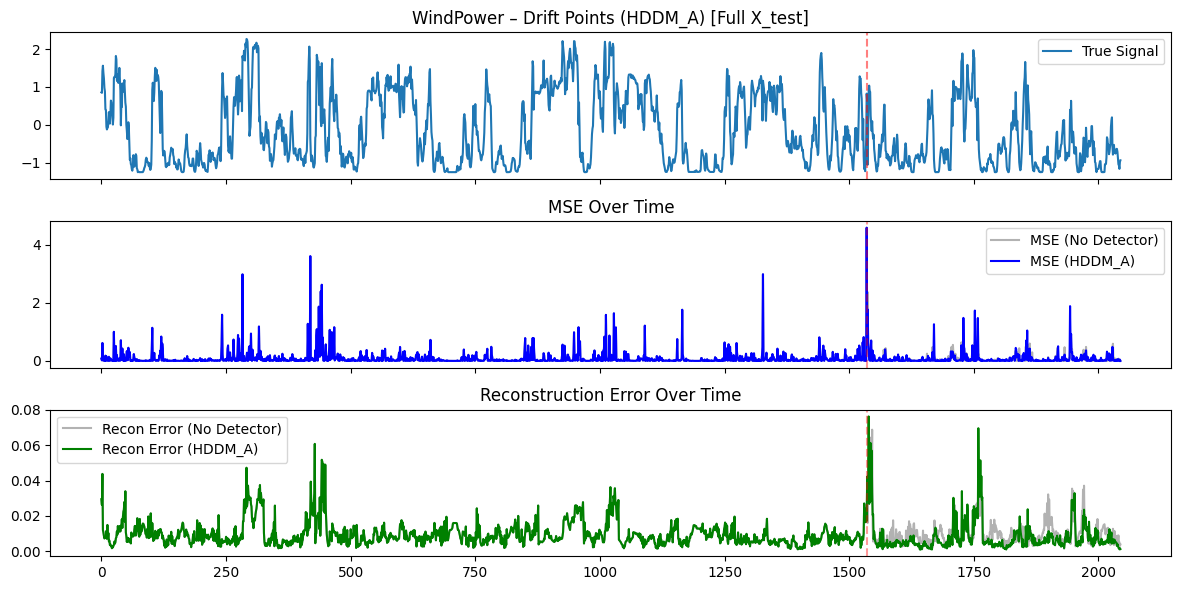

[Metric: manhattan] Detector: HDDM_W     | MSE: 0.0922 | Time: 40.30s | Drifts: 0


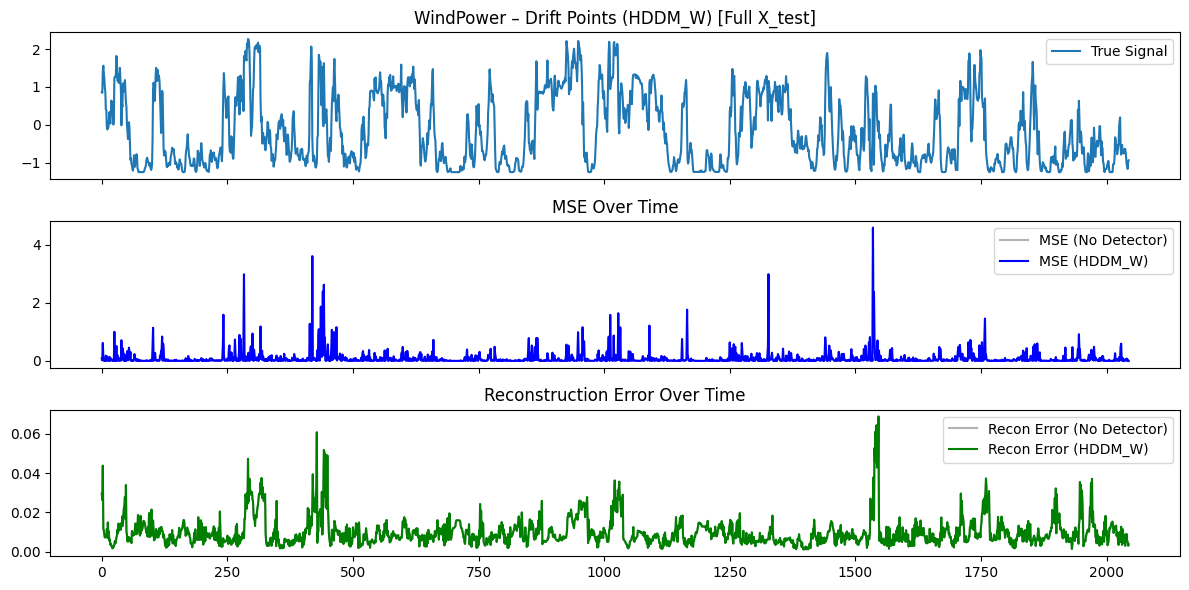

In [11]:
import copy

# Configurable parameters
recent_n_windows_ratio = 0.5
percentage = 0.75
append = True
metric = "manhattan"

detector_classes = {
    "None":        None,
    "ZScore":      lambda: ZScoreReconstructionDriftDetector(buffer_size=175, z_threshold=3.5, retain_fraction=0.1),
    "Percentile":  lambda: PercentileReconstructionDriftDetector(buffer_size=200, percentile=98.5, retain_fraction=0.1),
    "HDDM_A":      lambda: HDDM_A_Detector(delta=0.0019), #18
    "HDDM_W":      lambda: HDDM_W_Detector(delta=0.009, alpha=0.85), 
}

print(f"> Bottleneck size: {latent_dim}")

print("> Detectors and parameters:")
relevant_keys = {
    "ZScore": ["buffer_size", "z_threshold", "retain_fraction"],
    "Percentile": ["buffer_size", "percentile", "retain_fraction"],
    "HDDM_A": ["delta"],
    "HDDM_W": ["delta", "alpha"],
}

for name, constructor in detector_classes.items():
    if constructor is None:
        print(f"  {name}: None (no drift detection)")
    else:
        instance = constructor()
        params = instance.__dict__
        keys_to_show = relevant_keys.get(name, [])
        param_str = ", ".join(f"{k}={params[k]}" for k in keys_to_show if k in params)
        print(f"  {name}: {param_str}")

baseline_mse_per_step = {}
baseline_recon_per_step = {}

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    n_windows = len(X_test)

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    for detector_name, DetectorClass in detector_classes.items():
        print(f"[Metric: {metric}] Detector: {detector_name:<10}", end=" | ")

        current_ae = ae
        current_forecasters = {name: copy.deepcopy(model) for name, model in forecasters.items()}
        detector = None if DetectorClass is None else DetectorClass()

        preds, y_trues, reconstruction_errors, mse_per_step = [], [], [], []

        t0 = time.perf_counter()
        for i, (window, y_true) in enumerate(zip(X_test, y_test)):
            with torch.no_grad():
                inp = torch.tensor(window, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
                latent = current_ae.encode(window).cpu()
                recon = current_ae(inp).cpu().squeeze().numpy()
            recon_error = mean_squared_error(window, recon)
            reconstruction_errors.append(recon_error)

            best_name, best_dist = None, float("inf")
            for name, model in current_forecasters.items():
                for entry in model.rocs["latent"]:
                    d = compute_distance(latent, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name

            y_pred = current_forecasters[best_name].predict(window)
            preds.append(y_pred)
            y_trues.append(y_true)
            mse_per_step.append((y_pred - y_true) ** 2)

            if detector is not None:
                drift_signal = (y_pred - y_true) ** 2 if "HDDM" in detector_name else recon_error
                if detector.update(drift_signal, i):
                    full_n_windows = len(X_train) + len(X_val) + len(X_test)
                    recent_n_windows = int(recent_n_windows_ratio * full_n_windows)
                    all_X = np.vstack([X_train, X_val, X_test])
                    all_y = np.concatenate([y_train, y_val, y_test])
                    test_offset = len(X_train) + len(X_val)
                    end_idx = test_offset + i
                    start_idx = max(0, end_idx - recent_n_windows)
                    X_recent = all_X[start_idx:end_idx]
                    y_recent = all_y[start_idx:end_idx]
                    cutoff = int(len(X_recent) * percentage)
                    current_ae = retrain_autoencoder(X_recent[:cutoff], ds_name)
                    rebuild_rocs(current_ae, current_forecasters, X_recent[cutoff:], y_recent[int(len(y_recent)*percentage):], append=append)

        elapsed = time.perf_counter() - t0
        mse = mean_squared_error(y_trues, preds)
        drift_count = 0 if detector is None else len(detector.get_drift_points())
        print(f"MSE: {mse:.4f} | Time: {elapsed:.2f}s | Drifts: {drift_count}")

        if detector_name == "None":
            baseline_mse_per_step[ds_name] = mse_per_step
            baseline_recon_per_step[ds_name] = reconstruction_errors

        drift_points = detector.get_drift_points() if detector is not None else []

        fig, axs = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

        # Plot 1: True signal
        axs[0].plot(range(n_windows), y_test, label="True Signal")
        for idx in drift_points:
            axs[0].axvline(idx, color="red", linestyle="--", alpha=0.5)
        axs[0].set_title(f"{ds_name} – Drift Points ({detector_name}) [Full X_test]")
        axs[0].legend()

        # Plot 2: MSE over time
        axs[1].plot(baseline_mse_per_step.get(ds_name, []), label="MSE (No Detector)", color="gray", alpha=0.6)
        axs[1].plot(mse_per_step, label=f"MSE ({detector_name})", color="blue")
        for idx in drift_points:
            axs[1].axvline(idx, color="red", linestyle="--", alpha=0.4)
        axs[1].set_title("MSE Over Time")
        axs[1].legend()

        # Plot 3: Recon error over time
        axs[2].plot(baseline_recon_per_step.get(ds_name, []), label="Recon Error (No Detector)", color="gray", alpha=0.6)
        axs[2].plot(reconstruction_errors, label=f"Recon Error ({detector_name})", color="green")
        for idx in drift_points:
            axs[2].axvline(idx, color="red", linestyle="--", alpha=0.4)
        axs[2].set_title("Reconstruction Error Over Time")
        axs[2].legend()

        plt.tight_layout()
        plt.show()